In [17]:
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from konlpy.tag import Okt  # 형태소 분석기 사용
from sklearn.model_selection import train_test_split

# 한국어 불용어 리스트
korean_stopwords = ['의', '가', '이', '은', '는', '을', '를', '에', '과', '도', '으로', '한', '에서']

# 데이터 불러오기 (JSONL 파일)
file_path = '/data/ephemeral/home/data/documents.jsonl'

data = []

# JSONL 파일 로드
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# 한국어 형태소 분석기 설정
okt = Okt()

# 텍스트 전처리 함수 정의 (Unicode 이스케이프 해제 포함)
def preprocess_text(text):
    # Unicode 이스케이프 해제
    text = bytes(text, 'utf-8').decode('unicode_escape')
    # 공백 여러 개 -> 하나로
    text = re.sub(r'\s+', ' ', text)
    # 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    # 형태소 분석 및 불용어 제거
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in korean_stopwords]
    return ' '.join(tokens)

# 텍스트 전처리 적용
df['processed_text'] = df['content'].apply(preprocess_text)

# TF-IDF 변환 (한국어 형태소를 기반으로 TF-IDF 계산)
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_text']).toarray()

# 변환된 데이터 확인
print(X.shape)

(4272, 1000)


#### 1.1 TF-IDF로 키워드 추출

In [32]:
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from konlpy.tag import Okt  # 형태소 분석기 사용

# 한국어 불용어 리스트
korean_stopwords = ['의', '가', '이', '은', '는', '을', '를', '에', '과', '도', '으로', '한', '에서']

# 데이터 불러오기 (JSONL 파일)
file_path = '/data/ephemeral/home/data/documents.jsonl'

data = []

# JSONL 파일 로드
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# 한국어 형태소 분석기 설정
okt = Okt()

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 공백 여러 개 -> 하나로
    text = re.sub(r'\s+', ' ', text)
    # 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 형태소 분석 및 불용어 제거
def tokenize_text(text):
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in korean_stopwords]
    return tokens

# TF-IDF 변환 (tokenizer와 preprocessor를 konlpy의 형태소 분석으로 설정)
vectorizer = TfidfVectorizer(
    tokenizer=tokenize_text,  # konlpy의 형태소 분석을 사용한 토크나이저
    preprocessor=preprocess_text,  # 기본 전처리 함수 사용
    max_features=1000
)
X = vectorizer.fit_transform(df['content']).toarray()

# 단어 목록 추출 (TF-IDF에서 학습한 단어들)
tfidf_feature_names = vectorizer.get_feature_names_out()

# 각 문서에서 TF-IDF 상위 5개의 키워드 추출 함수
def extract_keywords(tfidf_vector, feature_names, top_n=5):
    sorted_indices = tfidf_vector.argsort()[::-1]
    top_keywords = [feature_names[i] for i in sorted_indices[:top_n]]
    return top_keywords

# 각 문서에서 키워드를 추출하여 새로운 컬럼에 저장
df['keywords'] = [extract_keywords(tfidf_vector, tfidf_feature_names) for tfidf_vector in X]

# 결과 출력 (키워드 상위 5개)
print(df[['content', 'keywords']].head())

# 변환된 데이터 확인
print("TF-IDF 행렬 크기:", X.shape)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                                             content                keywords
0  건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 ...   [에너지, 균형, 기간, 식단, 소비]
1  수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수...    [수소, 분자, 빠른, 평균, 속도]
2  종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플...  [종이, 자원, 재활용, 우리, 가능한]
3  마이애미파랑나비는 남부 플로리다에서 멸종 위기에 처한 종입니다. 이 나비의 개체수 ...   [건설, 나비, 서식지, 감소, 개체]
4  비버는 나무를 베고, 덤불과 관목을 모아 강과 개울에 댐을 만드는 것으로 알려져 있...   [감소, 서식지, 개체, 미칠, 생물]
TF-IDF 행렬 크기: (4272, 1000)


#### 1.2 RAKE로 키워드 추출

In [24]:
import pandas as pd
import json
import re
from konlpy.tag import Okt  # 형태소 분석기 사용
from rake_nltk import Rake  # RAKE 라이브러리

# 한국어 불용어 리스트
korean_stopwords = ['의', '가', '이', '은', '는', '을', '를', '에', '과', '도', '으로', '한', '에서']

# 데이터 불러오기 (JSONL 파일)
file_path = '/data/ephemeral/home/data/documents.jsonl'

data = []

# JSONL 파일 로드
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# 한국어 형태소 분석기 설정
okt = Okt()

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 공백 여러 개 -> 하나로
    text = re.sub(r'\s+', ' ', text)
    # 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 형태소 분석 및 불용어 제거
def tokenize_text(text):
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in korean_stopwords]
    return ' '.join(tokens)  # RAKE는 공백으로 구분된 문자열을 사용하므로 토큰을 다시 합침

# RAKE 키워드 추출 함수 (점수 없이 키워드만 반환)
def extract_keywords_rake(text):
    rake = Rake()  # RAKE 객체 생성
    rake.extract_keywords_from_text(text)  # 텍스트에서 키워드 추출
    # 키워드만 추출 (점수는 제외)
    keywords = [phrase for score, phrase in rake.get_ranked_phrases_with_scores()[:5]]
    return keywords

# 텍스트 전처리 및 RAKE를 이용한 키워드 추출
df['processed_text'] = df['content'].apply(preprocess_text)
df['tokenized_text'] = df['processed_text'].apply(tokenize_text)
df['keywords'] = df['tokenized_text'].apply(extract_keywords_rake)

# 결과 출력 (키워드 상위 5개)
print(df[['content', 'keywords']].head())

# 변환된 데이터 확인
print("문서 수:", df.shape[0])

                                             content  \
0  건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 ...   
1  수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수...   
2  종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플...   
3  마이애미파랑나비는 남부 플로리다에서 멸종 위기에 처한 종입니다. 이 나비의 개체수 ...   
4  비버는 나무를 베고, 덤불과 관목을 모아 강과 개울에 댐을 만드는 것으로 알려져 있...   

                                            keywords  
0  [건강한 사람 에너지 균형 평형 상태 로 유지 하는 것 중요합니다 에너지 균형 에너...  
1  [수소 산소 질소 가스 혼합물 평균 속도 가장 빠른 분자 수소 입니다 수소 분자 가...  
2  [종이 와 플라스틱 재활용 가능한 자원 입니다 중학교 과학 수업 우리 종이 와 플라...  
3  [마이애미 파랑 나비 남부 플로리다 멸종 위기 처 종 입니다 나비 개체 수 감소 초...  
4  [비버 나무 베고 덤불 관목 모아 강 개울 댐 만드는 것 알려져 있습니다 이러한 댐...  
문서 수: 4272


### 1.  머신러닝 분류 (Naive Bayes 사용) -> 정답 없으니 사용 불가

### 2. 딥러닝 분류 (Fine-tuning BERT) -> 이것도 답이 없어서... => 파인튜닝안하고 쓰니깐 결과 개똥
학습 데이터를 기반으로 문서의 내용을 카테고리별로 나누는 방법입니다. 대표적인 분류 알고리즘으로는 Naive Bayes, SVM, Decision Tree 등이 있습니다. 텍스트 데이터를 피처로 변환하여 훈련된 모델을 이용해 문서를 자동으로 분류할 수 있습니다.

In [6]:
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# from sklearn.preprocessing import LabelEncoder
# import torch

# # BERT 토크나이저 및 모델 준비
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category'].unique()))

# # 레이블 인코딩
# le = LabelEncoder()
# y_encoded = le.fit_transform(df['category'])

# # 데이터셋 준비
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# # 데이터 토크나이징
# encodings = tokenizer(df['processed_text'].tolist(), truncation=True, padding=True, max_length=128)
# dataset = Dataset(encodings, y_encoded)

# # 모델 학습 설정
# training_args = TrainingArguments(
#     output_dir='./results',
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=3,
#     weight_decay=0.01,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=dataset,
#     eval_dataset=dataset,
# )

# # 모델 학습
# trainer.train()

# # 모델 평가
# trainer.evaluate()


### 

In [30]:
from transformers import pipeline
from konlpy.tag import Okt

# konlpy의 Okt 형태소 분석기 설정
okt = Okt()

# 문서의 문맥을 기반으로 카테고리를 분류하는 NLP 모델 로드
classifier = pipeline("text-classification", model="klue/bert-base", tokenizer="klue/bert-base")

# 문서의 카테고리를 자동으로 결정하는 함수 (konlpy Okt 기반 토큰화 사용)
def determine_category(content):
    # 형태소 분석 및 토큰화 (konlpy 사용)
    tokens = okt.morphs(content)
    
    # BERT의 최대 입력 길이인 512 토큰을 초과하는 경우 자르기
    if len(tokens) > 512:
        tokens = tokens[:512]
    
    # 자른 토큰을 다시 문장으로 변환
    content_limited = " ".join(tokens)
    
    # BERT 모델로 분류
    result = classifier(content_limited, truncation=True, max_length=512)  # max_length를 지정하여 잘림을 보장
    label = result[0]['label']
    
    # 예시로 과학, 환경, 건강, 생태학/자연, 에너지로 구분
    if label == "과학":
        return "과학"
    elif label == "환경":
        return "환경"
    elif label == "건강":
        return "건강"
    elif label == "사회":
        return "사회"
    else:
        return "일반"

# 키워드 리스트를 문자열로 변환
df['keywords_str'] = df['keywords'].apply(lambda x: " ".join(x))

# 데이터프레임의 keywords_str 컬럼을 기반으로 카테고리 추가
df['predicted_category'] = df['keywords_str'].apply(determine_category)

# 결과 출력
print(df[['keywords', 'predicted_category']])

# 결과를 JSONL로 저장
output_file_path = 'tf_bert_doc_v2.jsonl'
df.to_json(output_file_path, orient='records', lines=True)

print(f"카테고리가 예측된 파일이 {output_file_path}에 저장되었습니다.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                      keywords predicted_category
0        [에너지, 균형, 기간, 식단, 소비]                 일반
1         [수소, 분자, 빠른, 평균, 속도]                 일반
2       [종이, 자원, 재활용, 우리, 가능한]                 일반
3        [건설, 나비, 서식지, 감소, 개체]                 일반
4        [감소, 서식지, 개체, 미칠, 생물]                 일반
...                        ...                ...
4267    [혈액, 제거, 심장, 이루어져, 물이]                 일반
4268      [인간, 작업, 과정, 수행, 사용]                 일반
4269       [여성, 된다, 적, 정상, 유발]                 일반
4270  [산소, 식물, 가스, 광합성, 이산화탄소]                 일반
4271     [시스템, 메모리, 공격, 보안, 자]                 일반

[4272 rows x 2 columns]
카테고리가 예측된 파일이 tf_bert_doc_v2.jsonl에 저장되었습니다.


In [31]:
import pandas as pd

# JSONL 파일 로드
file_path = 'tf_bert_doc_v2.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
bert_topic_counts = df['predicted_category'].value_counts()

# 결과 출력
print(bert_topic_counts)

predicted_category
일반    4272
Name: count, dtype: int64


### 3. 토픽 모델링 (LDA 사용)
문서의 주제를 자동으로 발견하여 비슷한 주제의 문서를 그룹화하는 방법입니다. 대표적인 알고리즘으로는 LDA(Latent Dirichlet Allocation)가 있으며, 문서의 숨겨진 주제를 발견하고 해당 주제를 기반으로 카테고리를 나눌 수 있습니다.

In [51]:
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from konlpy.tag import Okt  # 형태소 분석기 사용
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# 한국어 불용어 리스트
korean_stopwords = ['의', '가', '이', '은', '는', '을', '를', '에', '과', '도', '으로', '한', '에서']

# 데이터 불러오기 (JSONL 파일)
file_path = '/data/ephemeral/home/data/documents.jsonl'

data = []

# JSONL 파일 로드
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# 한국어 형태소 분석기 설정
okt = Okt()

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 공백 여러 개 -> 하나로
    text = re.sub(r'\s+', ' ', text)
    # 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 형태소 분석 및 불용어 제거
def tokenize_text(text):
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in korean_stopwords]
    return tokens

# TF-IDF 변환 (content에 대해 적용)
vectorizer = TfidfVectorizer(
    tokenizer=tokenize_text,  # konlpy의 형태소 분석을 사용한 토크나이저
    preprocessor=preprocess_text,  # 기본 전처리 함수 사용
    max_features=1000
)
X_content = vectorizer.fit_transform(df['content']).toarray()

# 단어 목록 추출 (TF-IDF에서 학습한 단어들)
tfidf_feature_names = vectorizer.get_feature_names_out()

# 각 문서에서 TF-IDF 상위 5개의 키워드 추출 함수
def extract_keywords(tfidf_vector, feature_names, top_n=5):
    sorted_indices = tfidf_vector.argsort()[::-1]
    top_keywords = [feature_names[i] for i in sorted_indices[:top_n]]
    return top_keywords

# 각 문서에서 키워드를 추출하여 새로운 컬럼에 저장
df['keywords'] = [extract_keywords(tfidf_vector, tfidf_feature_names) for tfidf_vector in X_content]

# 키워드 리스트를 문자열로 변환 (LDA에 입력할 수 있도록 처리)
df['keywords_str'] = df['keywords'].apply(lambda x: ' '.join(x))

# TF-IDF 변환 (추출된 키워드를 기반으로 적용)
vectorizer_keywords = TfidfVectorizer(max_features=1000)
X_keywords = vectorizer_keywords.fit_transform(df['keywords_str']).toarray()

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [63]:
import pandas as pd
import json
import re
from konlpy.tag import Okt  # 형태소 분석기 사용
from rake_nltk import Rake  # RAKE 라이브러리
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 한국어 불용어 리스트
korean_stopwords = ['의', '가', '이', '은', '는', '을', '를', '에', '과', '도', '으로', '한', '에서']

# 데이터 불러오기 (JSONL 파일)
file_path = '/data/ephemeral/home/data/documents.jsonl'

data = []

# JSONL 파일 로드
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# 한국어 형태소 분석기 설정
okt = Okt()

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 공백 여러 개 -> 하나로
    text = re.sub(r'\s+', ' ', text)
    # 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 형태소 분석 및 불용어 제거
def tokenize_text(text):
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in korean_stopwords]
    return ' '.join(tokens)  # RAKE는 공백으로 구분된 문자열을 사용하므로 토큰을 다시 합침

# RAKE 키워드 추출 함수 (점수 없이 키워드만 반환)
def extract_keywords_rake(text):
    rake = Rake()  # RAKE 객체 생성
    rake.extract_keywords_from_text(text)  # 텍스트에서 키워드 추출
    # 키워드만 추출 (점수는 제외)
    keywords = [phrase for score, phrase in rake.get_ranked_phrases_with_scores()[:5]]
    return keywords

# 텍스트 전처리 및 RAKE를 이용한 키워드 추출
df['processed_text'] = df['content'].apply(preprocess_text)
df['tokenized_text'] = df['processed_text'].apply(tokenize_text)
df['keywords'] = df['tokenized_text'].apply(extract_keywords_rake)

# 키워드 리스트를 문자열로 변환 (LDA에 입력할 수 있도록 처리)
df['keywords_str'] = df['keywords'].apply(lambda x: ' '.join(x))

# TF-IDF 변환 (추출된 키워드를 기반으로 적용)
vectorizer = TfidfVectorizer(max_features=1000)
X_keywords = vectorizer.fit_transform(df['keywords_str']).toarray()

In [43]:
# LDA 모델 학습 (추출된 키워드 기반)
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # n_components는 원하는 토픽 수
lda_model.fit(X_keywords)

# 문서별 토픽 분포 출력
doc_topic_dist = lda_model.transform(X_keywords)

# 각 문서에 대해 가장 관련성이 높은 토픽 할당
doc_topic_labels = np.argmax(doc_topic_dist, axis=1)

# LDA 토픽 정보를 데이터프레임에 추가
df['lda_topic'] = doc_topic_labels

# 결과 데이터프레임을 JSONL로 저장 (ensure_ascii=False 추가)
output_file_path = 'key_lda_topic_doc.jsonl'
df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)

print(f"LDA 토픽이 추가된 파일이 {output_file_path}에 저장되었습니다.")

LDA 토픽이 추가된 파일이 key_lda_topic_doc.jsonl에 저장되었습니다.


In [7]:
# import numpy as np
# from sklearn.decomposition import LatentDirichletAllocation

# # LDA 모델 학습
# lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # n_components는 원하는 토픽 수
# lda_model.fit(X)

# # 문서별 토픽 분포 출력
# doc_topic_dist = lda_model.transform(X)

# # 각 문서에 대해 가장 관련성이 높은 토픽 할당
# doc_topic_labels = np.argmax(doc_topic_dist, axis=1)

# # LDA 토픽 정보를 데이터프레임에 추가
# df['lda_topic'] = doc_topic_labels

# # 결과 데이터프레임을 JSONL로 저장 (ensure_ascii=False 추가)
# output_file_path = 'lda_topic_doc.jsonl'
# df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)

# print(f"LDA 토픽이 추가된 파일이 {output_file_path}에 저장되었습니다.")


LDA 토픽이 추가된 파일이 lda_topic_doc.jsonl에 저장되었습니다.


In [44]:
import pandas as pd

# JSONL 파일 로드
file_path = 'key_lda_topic_doc.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
lda_topic_counts = df['lda_topic'].value_counts()

# 결과 출력
print(lda_topic_counts)

lda_topic
4    952
3    928
0    893
2    767
1    732
Name: count, dtype: int64


In [45]:
import pandas as pd
import json

# JSONL 파일 로드
file_path = 'key_lda_topic_doc.jsonl'
data = []

# JSONL 파일 로드 및 processed_text 제거
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        record = json.loads(line)
        if 'processed_text' in record:
            del record['processed_text']  # 'processed_text' 필드 제거
        data.append(record)

# DataFrame으로 변환
df = pd.DataFrame(data)

# 결과를 다시 JSONL로 저장
output_file_path = 'key_lda_topic_doc_v2.jsonl'
df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)

output_file_path

'key_lda_topic_doc_v2.jsonl'

In [50]:
# kmeans_cluster가 1인 데이터들만 필터링하여 출력
kmeans_cluster_1_df = df[df['lda_topic'] == 4]

# kmeans_cluster가 1인 데이터들 출력
kmeans_cluster_1_df

,docid,src,content,tokenized_text,keywords,keywords_str,lda_topic
3,910107a6-2a42-41a2-b337-fbf22d6440fe,ko_ai2_arc__ARC_Challenge__test,마이애미파랑나비는 남부 플로리다에서 멸종 위기에 처한 종입니다. 이 나비의 개체수 ...,마이애미 파랑 나비 남부 플로리다 멸종 위기 처 종 입니다 나비 개체 수 감소 초래...,[마이애미 파랑 나비 남부 플로리다 멸종 위기 처 종 입니다 나비 개체 수 감소 초...,마이애미 파랑 나비 남부 플로리다 멸종 위기 처 종 입니다 나비 개체 수 감소 초래...,4
4,74f22819-1a8e-4646-8a9d-13323de8cdb8,ko_ai2_arc__ARC_Challenge__validation,"비버는 나무를 베고, 덤불과 관목을 모아 강과 개울에 댐을 만드는 것으로 알려져 있...",비버 나무 베고 덤불 관목 모아 강 개울 댐 만드는 것 알려져 있습니다 이러한 댐 ...,[비버 나무 베고 덤불 관목 모아 강 개울 댐 만드는 것 알려져 있습니다 이러한 댐...,비버 나무 베고 덤불 관목 모아 강 개울 댐 만드는 것 알려져 있습니다 이러한 댐 ...,4
10,6b6971ff-885f-48cf-adca-46bbd01041e6,ko_mmlu__high_school_biology__test,"동물들은 사냥 당하는 위험에 처했을 때, 환경의 색상에 녹아들 수 있게 하는 색상 ...",동물 들 사냥 당하는 위험 처 했을 때 환경 색상 녹 아들 수 있게 하는 색상 체계...,[동물 들 사냥 당하는 위험 처 했을 때 환경 색상 녹 아들 수 있게 하는 색상 체...,동물 들 사냥 당하는 위험 처 했을 때 환경 색상 녹 아들 수 있게 하는 색상 체계...,4
12,6a07c17e-ec09-4383-9f77-c7baeb641bac,ko_ai2_arc__ARC_Challenge__validation,아메리카 알리게이터는 플로리다 습지에서 흔하게 발견되는 동물입니다. 그들은 주로 개...,아메리카 알리 게 터 플로리다 습지 흔하게 발견 되는 동물 입니다 그 들 주로 개구...,[아메리카 알리 게 터 플로리다 습지 흔하게 발견 되는 동물 입니다 그 들 주로 개...,아메리카 알리 게 터 플로리다 습지 흔하게 발견 되는 동물 입니다 그 들 주로 개구...,4
16,2318a89f-a4b0-41fe-8e25-23530d94588f,ko_mmlu__college_biology__test,쌍떡잎식물의 줄기는 중심에 목수조직을 가지고 있습니다. 이 목수조직은 유조직으로 구...,쌍떡잎식물 줄기 중심 목수 조직 가지 고 있습니다 목수 조직 유 조직 구성 되어 있...,[쌍떡잎식물 줄기 중심 목수 조직 가지 고 있습니다 목수 조직 유 조직 구성 되어 ...,쌍떡잎식물 줄기 중심 목수 조직 가지 고 있습니다 목수 조직 유 조직 구성 되어 있...,4
...,...,...,...,...,...,...,...
4254,c0e9e34f-a650-426b-b172-04e33387dff4,ko_ai2_arc__ARC_Challenge__validation,아프리카 사바나의 생태계는 다양한 생물들이 서로 협력하여 살아가는 특별한 관계를 가...,아프리카 사바나 생태계 다양한 생물 들 서로 협력 하여 살아가는 특별한 관계 가지 ...,[아프리카 사바나 생태계 다양한 생물 들 서로 협력 하여 살아가는 특별한 관계 가지...,아프리카 사바나 생태계 다양한 생물 들 서로 협력 하여 살아가는 특별한 관계 가지 ...,4
4258,5594ee21-e922-43b3-aea8-51ed12331f16,ko_ai2_arc__ARC_Challenge__train,해변이 회복되는 과정에서 선구 식물이 되기 위해 식물이 가져야 할 가장 중요한 특성...,해변 회복 되는 과정 선구 식물 되기 위해 식물 가져야 할 가장 중요한 특성 방해 ...,[해변 회복 되는 과정 선구 식물 되기 위해 식물 가져야 할 가장 중요한 특성 방해...,해변 회복 되는 과정 선구 식물 되기 위해 식물 가져야 할 가장 중요한 특성 방해 ...,4
4262,57472656-1dcf-4148-b23f-9318540d4bd0,ko_ai2_arc__ARC_Challenge__train,토양은 다양한 특성을 가지고 있습니다. 그 중에서도 영양소를 포함하고 있다는 것을 ...,토양 다양한 특성 가지 고 있습니다 그 중 에서도 영양소 포함 하고 있다는 것 가장...,[토양 다양한 특성 가지 고 있습니다 그 중 에서도 영양소 포함 하고 있다는 것 가...,토양 다양한 특성 가지 고 있습니다 그 중 에서도 영양소 포함 하고 있다는 것 가장...,4
4267,ae28101b-a42e-45b7-b24b-4ea0f1fb2d50,ko_ai2_arc__ARC_Challenge__train,비뇨기계와 순환계는 혈액이 신장을 통과하면서 폐기물과 물이 제거될 때 관여하는 두 ...,비뇨기계 와 순환계 혈액 신장 통과 하면서 폐기물 물이 제거 될 때 관여 하는 두 ...,[비뇨기계 와 순환계 혈액 신장 통과 하면서 폐기물 물이 제거 될 때 관여 하는 두...,비뇨기계 와 순환계 혈액 신장 통과 하면서 폐기물 물이 제거 될 때 관여 하는 두 ...,4


### 4.클러스터링
문서 간의 유사성을 측정하고, 비슷한 문서끼리 자동으로 그룹을 지어주는 방법입니다. K-means, Hierarchical Clustering 등의 알고리즘을 사용할 수 있습니다. 이 방법은 사전에 정의된 카테고리가 없을 때 유용할 수 있습니다.

In [ ]:
!pip install matplotlib

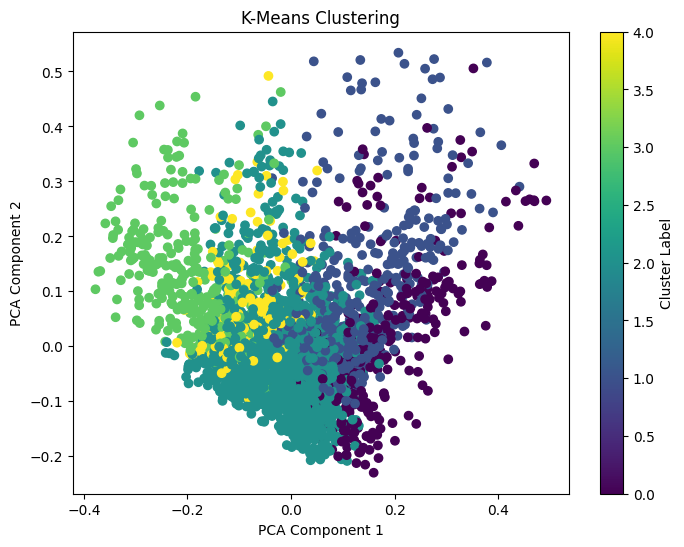

클러스터 라벨이 추가된 파일이 key_kmeans_cluster_doc.jsonl에 저장되었습니다.


In [65]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# K-Means 클러스터링
kmeans_model = KMeans(n_clusters=5, random_state=42)  # 클러스터 수는 5로 설정 (필요에 따라 조정)
kmeans_model.fit(X_keywords)

# 클러스터 라벨 추가
df['kmeans_cluster'] = kmeans_model.labels_

# PCA를 사용한 2D 시각화
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_keywords)

# 시각화 저장
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['kmeans_cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# 결과 데이터프레임을 JSONL로 저장
output_file_path = 'key_kmeans_cluster_doc.jsonl'
df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)

print(f"클러스터 라벨이 추가된 파일이 {output_file_path}에 저장되었습니다.")

In [66]:
import pandas as pd

# JSONL 파일 로드
file_path = 'key_kmeans_cluster_doc.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
kmeans_cluster_counts = df['kmeans_cluster'].value_counts()

# 결과 출력
print(kmeans_cluster_counts)

kmeans_cluster
2    2659
1     572
0     360
3     350
4     331
Name: count, dtype: int64


In [67]:
import pandas as pd
import json

# JSONL 파일 로드
file_path = 'key_kmeans_cluster_doc.jsonl'
data = []

# JSONL 파일 로드 및 processed_text 제거
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        record = json.loads(line)
        if 'processed_text' in record:
            del record['processed_text']  # 'processed_text' 필드 제거
        data.append(record)

# DataFrame으로 변환
df = pd.DataFrame(data)

# 결과를 다시 JSONL로 저장
output_file_path = 'key_kmeans_cluster_doc_v2.jsonl'
df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)

output_file_path

'key_kmeans_cluster_doc_v2.jsonl'

In [72]:
# kmeans_cluster가 1인 데이터들만 필터링하여 출력
kmeans_cluster_1_df = df[df['kmeans_cluster'] == 4]

# kmeans_cluster가 1인 데이터들 출력
kmeans_cluster_1_df

,docid,src,content,tokenized_text,keywords,keywords_str,kmeans_cluster
1,4a437e7f-16c1-4c62-96b9-f173d44f4339,ko_mmlu__conceptual_physics__test,"수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수...",수소 산소 질소 가스 혼합물 평균 속도 가장 빠른 분자 수소 입니다 수소 분자 가장...,[수소 산소 질소 가스 혼합물 평균 속도 가장 빠른 분자 수소 입니다 수소 분자 가...,수소 산소 질소 가스 혼합물 평균 속도 가장 빠른 분자 수소 입니다 수소 분자 가장...,4
17,ab0e5e19-5a86-4c3c-b9bd-8298a835f066,ko_mmlu__conceptual_physics__test,"원소가 베타 입자를 방출할 때, 그 원소의 원자 번호는 1만큼 증가한다. 이는 원소...",원소 베타 입자 방출 할 때 그 원소 원자 번호 1만 큼 증가 한다 이는 원소 핵 ...,[원소 베타 입자 방출 할 때 그 원소 원자 번호 1만 큼 증가 한다 이는 원소 핵...,원소 베타 입자 방출 할 때 그 원소 원자 번호 1만 큼 증가 한다 이는 원소 핵 ...,4
32,012c2796-eea5-4409-bdb5-4fcf5dc5a5d3,ko_mmlu__conceptual_physics__test,원소가 알파 입자를 방출할 때 결과물의 원자 번호는 2만큼 감소합니다. 이는 알파 ...,원소 알파 입자 방출 할 때 결과물 원자 번호 2만 큼 감소 합니다 이는 알파 붕괴...,[원소 알파 입자 방출 할 때 결과물 원자 번호 2만 큼 감소 합니다 이는 알파 붕...,원소 알파 입자 방출 할 때 결과물 원자 번호 2만 큼 감소 합니다 이는 알파 붕괴...,4
36,814dd12b-62a4-4a79-99d2-82fa39ba76e3,ko_ai2_arc__ARC_Challenge__train,지질학자들은 암석의 상대 연대를 결정하기 위해 종종 질량 분석계를 사용합니다. 이 ...,지질학자 들 암석 상대 연대 결정 하기 위해 종종 질량 분석 계 사용 합니다 분석 ...,[지질학자 들 암석 상대 연대 결정 하기 위해 종종 질량 분석 계 사용 합니다 분석...,지질학자 들 암석 상대 연대 결정 하기 위해 종종 질량 분석 계 사용 합니다 분석 ...,4
37,f039886e-c38c-4ba9-a044-63028bfdf7c2,ko_ai2_arc__ARC_Challenge__validation,알루미늄 염화물과 마그네슘이 반응하여 마그네슘 염화물과 알루미늄이 생성되는 반응식은...,알루미늄 염화물 마그네슘 반응 하여 마그네슘 염화물 알루미늄 생 성 되는 반응 식 ...,[2 2 al 입니다 반응 식 균형 화학 반응 식 입니다 알루미늄 염화물 2 몰과 ...,2 2 al 입니다 반응 식 균형 화학 반응 식 입니다 알루미늄 염화물 2 몰과 마...,4
...,...,...,...,...,...,...,...
4207,4e4d7110-4d9f-4f39-b107-49456b3a9304,ko_mmlu__college_chemistry__validation,NaBH4는 화학적인 환원제로 알려져 있습니다. 이 화합물은 D-자일로오스를 환원할...,NaBH 4 화학 적 인 환원제 로 알려져 있습니다 화합물 D 자일로오스 환원 할 ...,[자일로오스 환원 하면 uv 가시광 성 방출 예측 하는 데 사용 될 수 있습니다 u...,자일로오스 환원 하면 uv 가시광 성 방출 예측 하는 데 사용 될 수 있습니다 uv...,4
4224,ea8db0a6-b204-4a7b-892c-7c47db39e014,ko_ai2_arc__ARC_Challenge__test,화학적 변화란 물질이 다른 물질로 변하는 과정을 말합니다. 이러한 변화는 다양한 형...,화학 적 변화 란 물질 다른 물질 로 변하는 과정 말 합니다 이러한 변화 다양한 형...,[화학 적 변화 란 물질 다른 물질 로 변하는 과정 말 합니다 이러한 변화 다양한 ...,화학 적 변화 란 물질 다른 물질 로 변하는 과정 말 합니다 이러한 변화 다양한 형...,4
4228,ffd02b96-cda9-4ef0-b232-de715a38b137,ko_mmlu__conceptual_physics__test,"원자는 원소의 기본 단위로, 원자 번호는 원소를 구분하는 번호입니다. 특정 원소가 ...",원자 원소 기본 단위 로 원자 번호 원소 구분 하는 번호 입니다 특정 원소 1 개 ...,[원자 원소 기본 단위 로 원자 번호 원소 구분 하는 번호 입니다 특정 원소 1 개...,원자 원소 기본 단위 로 원자 번호 원소 구분 하는 번호 입니다 특정 원소 1 개 ...,4
4229,1266a809-6fd7-4fb4-ae7e-bfeb77bf051c,ko_ai2_arc__ARC_Challenge__validation,생명 작용은 에너지가 필요합니다. 생화학적 작용은 특정 반응이 수반합니다. 모든 동...,생명 작용 에너지 필요합니다 생화학 적 작용 특정 반응 수반 합니다 모든 동물 에게...,[생명 작용 에너지 필요합니다 생화학 적 작용 특정 반응 수반 합니다 모든 동물 에...,생명 작용 에너지 필요합니다 생화학 적 작용 특정 반응 수반 합니다 모든 동물 에게...,4


### 5.깔깔깔 수동으로 직접 다 해버리겠다~

In [1]:
import pandas as pd
import json

# JSONL 파일 로드
file_path = '/data/ephemeral/home/data/documents.jsonl'
data = []

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# DataFrame으로 변환
df = pd.DataFrame(data)

# 수동으로 라벨을 입력하는 함수
def manual_labeling(content):
    print(f"문서 내용: {content[:100]}...")  # 문서의 앞부분 100자만 출력
    label = input("이 문서의 카테고리를 입력하세요 (예: 과학, 환경, 건강, 사회, 일반): ")
    return label

# 각 문서에 대해 수동으로 라벨 입력
df['label'] = df['content'].apply(manual_labeling)

# 결과를 JSONL로 저장
output_file_path = 'labeled_documents.jsonl'
df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)

print(f"라벨이 추가된 파일이 {output_file_path}에 저장되었습니다.")


문서 내용: 건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 에너지 섭취와 에너지 소비의 수학적 동등성을 의미합니다. 일반적으로 건강한 사람은 1-2주의 기간...
문서 내용: 수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수소 분자는 가장 가볍고 작은 원자로 구성되어 있기 때문에 다른 분자들보다 더 빠르게 움직입니다. ...
문서 내용: 종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플라스틱 가방을 재활용하는 프로젝트를 진행하고 있습니다. 이 프로젝트를 통해 우리는 환경 보호의 중...
문서 내용: 마이애미파랑나비는 남부 플로리다에서 멸종 위기에 처한 종입니다. 이 나비의 개체수 감소를 초래했을 가능성이 가장 높은 요인은 주택 건설 증가입니다. 남부 플로리다 지역에서는 최근 ...
문서 내용: 비버는 나무를 베고, 덤불과 관목을 모아 강과 개울에 댐을 만드는 것으로 알려져 있습니다. 이러한 댐은 비버의 서식지를 만들어주고 다양한 동물들에게도 이점을 제공합니다. 그러나 최...
문서 내용: AIDS에 직면한 민족문화 공동체 연구에 따르면, 한 해 동안 섹스 파트너가 한 명 이상이었던 사람들 중에서 남아시아인 남성이 영어권 카리브인 남성보다 더 많다고 보고했다. 이 연...
문서 내용: 헤르페스 감염은 화학요법을 통해 통제할 수 있습니다. 화학요법은 항바이러스 약물을 사용하여 헤르페스 바이러스의 복제를 억제하고 증상을 완화시키는 방법입니다. 이러한 약물은 헤르페스...
문서 내용: 노인들이 기억력을 향상시키고 기억력 저하에 대한 불안을 줄일 수 있는 경우는 다양합니다. 그 중 대표적인 경우로는 노인들은 기억과 노화에 대해 학습하고 몇 가지 기술을 배울 때 많...
문서 내용: 강한 바람이 삼림 지대의 소나무를 넘어뜨렸을 때, 우거진 숲 지붕에 틈이 생겨 땅에 햇빛이 비치게 되었습니다. 이로 인해 증가한 햇빛은 산딸기 식물이 빽빽하게 자랄 수 있게 해 어...
문

In [76]:
from openai import OpenAI
import traceback
import os
import json

# OpenAI API 키 설정
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

client = OpenAI()

# GPT-3.5를 사용한 카테고리 분류 함수
def classify_category_with_gpt(content):
    prompt = f"""
    다음 문서를 읽고 해당하는 카테고리를 선택하세요:
    카테고리: 과학, 건강, 환경, 사회, 일반
    문서: "{content}"
    카테고리를 선택하세요:
    """
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a classifier that assigns a category to a given document."},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        max_tokens=10
    )
    
    # GPT-3.5의 응답에서 카테고리 추출
    category = response.choices[0].message.content
    return category

# 모든 문서에 대해 GPT-3.5로 카테고리 분류
def categorize_documents_with_gpt(df):
    df['gpt_category'] = df['content'].apply(classify_category_with_gpt)
    return df

# 분류된 문서들을 JSONL로 저장
def save_categorized_documents(df, output_file_path='gpt_cate_docs.jsonl'):
    df.to_json(output_file_path, orient='records', lines=True, force_ascii=False)
    print(f"Categorized documents saved to {output_file_path}")

# 기존 문서 데이터 불러오기 (documents.jsonl 사용)
df_docs = pd.read_json('/data/ephemeral/home/data/documents.jsonl', lines=True)

# 문서를 GPT-3.5로 카테고리 분류
df_docs = categorize_documents_with_gpt(df_docs)

# 분류된 문서를 저장
save_categorized_documents(df_docs, 'gpt_cate_docs.jsonl')

Categorized documents saved to gpt_cate_docs.jsonl


In [82]:
import json
import pandas as pd

file_path = 'gpt_cate_docs.jsonl'

categories = []
with open(file_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        if 'gpt_category' in doc:
            categories.append(doc['gpt_category'])


unique_categories = pd.Series(categories).unique()
print("Unique GPT Categories:", unique_categories)


Unique GPT Categories: ['건강' '과학' '환경' '사회' '일반']


In [83]:
import pandas as pd

# JSONL 파일 로드
file_path = 'gpt_cate_docs.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
kmeans_cluster_counts = df['gpt_category'].value_counts()

# 결과 출력
print(kmeans_cluster_counts)

gpt_category
과학    2959
환경     599
건강     515
사회     191
일반       8
Name: count, dtype: int64


In [4]:
import json
import pandas as pd

file_path = 'gpt_cate_docs.jsonl'

categories = []
with open(file_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        if 'src' in doc:
            categories.append(doc['src'])


unique_categories = pd.Series(categories).unique()
print("Unique GPT Categories:", unique_categories)


Unique GPT Categories: ['ko_mmlu__nutrition__test' 'ko_mmlu__conceptual_physics__test'
 'ko_ai2_arc__ARC_Challenge__test' 'ko_ai2_arc__ARC_Challenge__validation'
 'ko_mmlu__human_sexuality__test' 'ko_mmlu__virology__test'
 'ko_mmlu__human_aging__test' 'ko_ai2_arc__ARC_Challenge__train'
 'ko_mmlu__high_school_biology__test' 'ko_mmlu__high_school_physics__test'
 'ko_mmlu__college_biology__test' 'ko_mmlu__computer_security__test'
 'ko_mmlu__anatomy__test' 'ko_mmlu__college_physics__train'
 'ko_mmlu__conceptual_physics__validation' 'ko_mmlu__virology__validation'
 'ko_mmlu__medical_genetics__test' 'ko_mmlu__electrical_engineering__test'
 'ko_mmlu__college_medicine__train' 'ko_mmlu__college_chemistry__test'
 'ko_mmlu__college_medicine__test' 'ko_mmlu__astronomy__test'
 'ko_mmlu__college_computer_science__validation'
 'ko_mmlu__global_facts__validation'
 'ko_mmlu__high_school_chemistry__test'
 'ko_mmlu__electrical_engineering__train' 'ko_mmlu__global_facts__test'
 'ko_mmlu__human_aging__vali

In [5]:
# import json

# # 데이터셋을 주제별로 분류하기 위한 매핑
# dataset_to_category = {
#     'nutrition': '생물학 및 의학',
#     'human_sexuality': '생물학 및 의학',
#     'virology': '생물학 및 의학',
#     'human_aging': '생물학 및 의학',
#     'high_school_biology': '생물학 및 의학',
#     'college_biology': '생물학 및 의학',
#     'anatomy': '생물학 및 의학',
#     'medical_genetics': '생물학 및 의학',
#     'college_medicine': '생물학 및 의학',
    
#     'conceptual_physics': '물리학',
#     'high_school_physics': '물리학',
#     'college_physics': '물리학',
#     'astronomy': '물리학',

#     'high_school_chemistry': '화학',
#     'college_chemistry': '화학',

#     'college_computer_science': '컴퓨터 과학 및 전기공학',
#     'high_school_computer_science': '컴퓨터 과학 및 전기공학',
#     'electrical_engineering': '컴퓨터 과학 및 전기공학',
#     'computer_security': '컴퓨터 과학 및 전기공학',

#     'global_facts': '사회 과학',
    
#     'ARC_Challenge': 'AI 및 챌린지 데이터셋'
# }

# # 주어진 데이터셋 이름에서 주제를 추출하는 함수
# def categorize_dataset(dataset_name):
#     for key in dataset_to_category:
#         if key in dataset_name:
#             return dataset_to_category[key]
#     return '기타'  # 매칭되지 않는 경우 '기타'로 분류

# # documents.jsonl 파일 경로
# input_file = '/data/ephemeral/home/data/documents.jsonl'
# output_file = 'src_cate_documents.jsonl'

# # JSONL 파일을 읽고 주제에 맞게 분류하여 category 필드를 추가
# with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
#     for line in infile:
#         document = json.loads(line)
#         # src 필드에서 데이터셋 이름 추출 (가정: 'src'에 데이터셋 이름이 있음)
#         dataset_name = document.get('src', '')

#         # 데이터셋 이름을 기반으로 category를 추가
#         category = categorize_dataset(dataset_name)
#         document['category'] = category

#         # 분류된 결과를 다시 JSONL로 저장
#         json.dump(document, outfile, ensure_ascii=False)
#         outfile.write('\n')

# print("Documents have been categorized and saved with 'category' field.")


Documents have been categorized and saved with 'category' field.


In [10]:
import os
import json
from elasticsearch import Elasticsearch, helpers
from sentence_transformers import SentenceTransformer, models
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import AutoTokenizer, AutoModel
import torch
import re
import warnings

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# 아래부터는 실제 RAG를 구현하는 코드입니다.
from openai import OpenAI
import traceback

# OpenAI API 키를 환경변수에 설정
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"
client = OpenAI()
# 사용할 모델을 설정(여기서는 gpt-3.5-turbo-1106 모델 사용)
llm_model = "gpt-3.5-turbo-1106"

In [13]:
import json

# OpenAI GPT 모델을 사용한 텍스트 분석 함수
def analyze_content_and_categorize(content):
    prompt = f"""
    다음 문서는 어떤 주제에 해당합니까? 가능한 주제는 다음과 같습니다: 
    - 생물학
    - 물리학
    - 화학
    - 컴퓨터 및 전기공학
    - 사회 과학
    주제를 선택해 주세요.
    
    문서 내용:
    {content}
    """
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a classifier that assigns a category to a given document."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=10,
        temperature=0
    )
    
    # GPT 응답에서 주제를 추출
    category = response.choices[0].message.content
    return category if category else '기타'

# 데이터셋을 주제별로 분류하기 위한 매핑
dataset_to_category = {
    'nutrition': '생물학',
    'human_sexuality': '생물학',
    'virology': '생물학',
    'human_aging': '생물학',
    'high_school_biology': '생물학',
    'college_biology': '생물학',
    'anatomy': '생물학',
    'medical_genetics': '생물학',
    'college_medicine': '생물학',
    
    'conceptual_physics': '물리학',
    'high_school_physics': '물리학',
    'college_physics': '물리학',
    'astronomy': '물리학',

    'high_school_chemistry': '화학',
    'college_chemistry': '화학',

    'college_computer_science': '컴퓨터 및 전기공학',
    'high_school_computer_science': '컴퓨터 및 전기공학',
    'electrical_engineering': '컴퓨터 및 전기공학',
    'computer_security': '컴퓨터 및 전기공학',

    'global_facts': '사회 과학',
    
    # 'ARC_Challenge'는 별도 처리
}

# 주어진 데이터셋 이름에서 주제를 추출하는 함수
def categorize_dataset(dataset_name, content=None):
    for key in dataset_to_category:
        if key in dataset_name:
            return dataset_to_category[key]
    
    # ARC_Challenge가 있는 경우, 내용을 분석하여 주제 분류
    if 'ARC_Challenge' in dataset_name and content:
        return analyze_content_and_categorize(content)
    
    return '기타'  # 매칭되지 않는 경우 '기타'로 분류

# documents.jsonl 파일 경로
input_file = '/data/ephemeral/home/data/documents.jsonl'
output_file = 'src_cate_documents.jsonl'

# JSONL 파일을 읽고 주제에 맞게 분류하여 category 필드를 추가
with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
    for line in infile:
        document = json.loads(line)
        # src 필드에서 데이터셋 이름 추출 (가정: 'src'에 데이터셋 이름이 있음)
        dataset_name = document.get('src', '')
        content = document.get('content', '')  # 문서 내용 가져오기

        # 데이터셋 이름을 기반으로 category를 추가
        category = categorize_dataset(dataset_name, content)
        document['category'] = category

        # 분류된 결과를 다시 JSONL로 저장
        json.dump(document, outfile, ensure_ascii=False)
        outfile.write('\n')

print("Documents have been categorized and saved with 'category' field.")

Documents have been categorized and saved with 'category' field.


In [51]:
import json
import pandas as pd

file_path = 'src_cate_documents.jsonl'

categories = []
with open(file_path, 'r') as f:
    for line in f:
        doc = json.loads(line)
        if 'category' in doc:
            categories.append(doc['category'])


unique_categories = pd.Series(categories).unique()
print("Unique GPT Categories:", unique_categories)


Unique GPT Categories: ['생물학 및 의학' '물리학' '화학' '컴퓨터 과학 및 전기공학' '기타']


In [50]:
import pandas as pd

# JSONL 파일 로드
file_path = 'src_cate_documents.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
kmeans_cluster_counts = df['category'].value_counts()

# 결과 출력
print(kmeans_cluster_counts)

category
생물학 및 의학         1946
물리학              1289
화학                510
컴퓨터 과학 및 전기공학     334
기타                193
Name: count, dtype: int64


In [56]:
import json

# 파일 경로 설정
summarized_file = 'summarized_documents.jsonl'  # 로컬에서 읽을 summarized_documents 파일 경로
src_cate_file = 'src_cate_documents.jsonl'      # 로컬에서 읽을 src_cate_documents 파일 경로
output_file = 'sum_src_cate_documents.jsonl'          # 결과 파일을 저장할 경로

# 두 파일을 읽어서 src 필드를 기준으로 category 데이터 붙이기
summarized_docs = []
src_cate_docs = {}

# src_cate_documents.jsonl 파일 읽기
with open(src_cate_file, 'r', encoding='utf-8') as f:
    for line in f:
        doc = json.loads(line)
        src = doc.get('src')
        category = doc.get('category')
        if src:
            src_cate_docs[src] = category

# summarized_documents.jsonl 파일 읽고 category 추가
with open(summarized_file, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        doc = json.loads(line)
        src = doc.get('src')
        # category 붙여넣기
        if src and src in src_cate_docs:
            doc['category'] = src_cate_docs[src]
        else:
            doc['category'] = 'Unknown'
        
        # 출력 파일에 저장
        f_out.write(json.dumps(doc, ensure_ascii=False) + '\n')

print("병합 작업이 완료되었습니다. 파일이 저장되었습니다:", output_file)


병합 작업이 완료되었습니다. 파일이 저장되었습니다: sum_src_cate_documents.jsonl


In [57]:
import json

# category 변환을 위한 매핑 딕셔너리
category_mapping = {
    "생물학 및 의학": "생물학",
    "물리학": "물리",
    "화학": "화학",
    "컴퓨터 과학 및 전기공학": "컴퓨터과학",
    "기타": "기타"  # 다른 카테고리도 필요하면 추가
}

# 입력 파일과 출력 파일 경로 설정
input_file = 'sum_src_cate_documents.jsonl'
output_file = 'up_sum_src_cate_documents.jsonl'

# JSONL 파일을 읽고 category 필드 값을 수정한 후 저장
with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
    for line in infile:
        if line.strip():  # 빈 줄이 아닌 경우만 처리
            document = json.loads(line)
            # category 값 변환
            original_category = document.get('category', '')
            new_category = category_mapping.get(original_category, original_category)  # 변환 매핑이 없으면 원래 값 유지
            document['category'] = new_category

            # 수정된 문서를 다시 JSONL 형식으로 저장
            json.dump(document, outfile, ensure_ascii=False)
            outfile.write('\n')

print("Category 변환이 완료되었습니다. 수정된 파일은 'updated_src_gpt_cate_docs.jsonl'에 저장되었습니다.")


Category 변환이 완료되었습니다. 수정된 파일은 'updated_src_gpt_cate_docs.jsonl'에 저장되었습니다.


In [60]:
import pandas as pd

# JSONL 파일 로드
file_path = 'src_cate_documents.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
src = df['src'].value_counts()

# 결과 출력
src

src
ko_ai2_arc__ARC_Challenge__test          943
ko_ai2_arc__ARC_Challenge__train         866
ko_ai2_arc__ARC_Challenge__validation    238
ko_mmlu__conceptual_physics__test        211
ko_mmlu__nutrition__test                 168
                                        ... 
ko_mmlu__high_school_physics__train        1
ko_mmlu__college_chemistry__train          1
ko_mmlu__nutrition__train                  1
ko_mmlu__high_school_chemistry__train      1
ko_mmlu__high_school_biology__train        1
Name: count, Length: 63, dtype: int64

In [62]:
%pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_1064424/1327336911.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=src_counts.values, y=src_counts.index, palette='viridis')


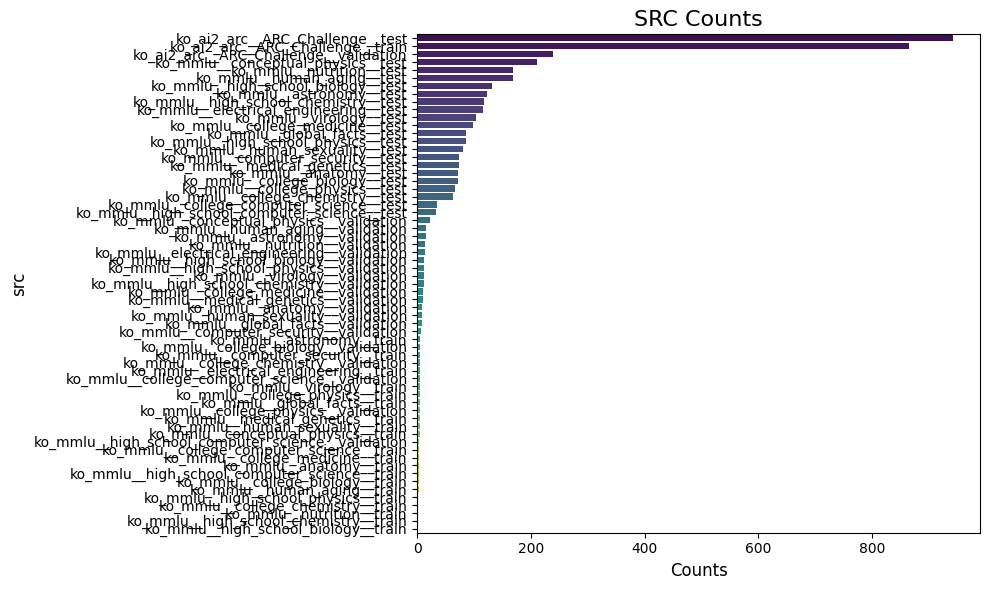

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# JSONL 파일 로드
file_path = 'src_cate_documents.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
src_counts = df['src'].value_counts()

# 시각화 설정
plt.figure(figsize=(10, 6))
sns.barplot(x=src_counts.values, y=src_counts.index, palette='viridis')
plt.title('SRC Counts', fontsize=16)
plt.xlabel('Counts', fontsize=12)
plt.ylabel('src', fontsize=12)
plt.tight_layout()

# 그래프 출력
plt.show()

/tmp/ipykernel_1064424/348887187.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=src_counts.values, y=src_counts.index, palette='viridis')
/tmp/ipykernel_1064424/348887187.py:18: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1064424/348887187.py:18: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1064424/348887187.py:18: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1064424/348887187.py:18: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1064424/348887187.py:18: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu

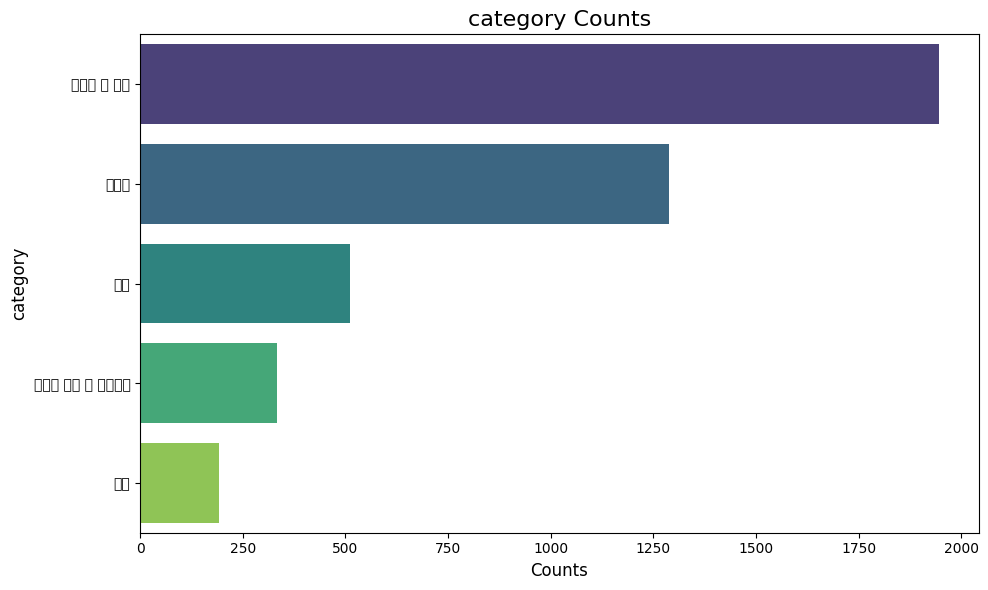

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# JSONL 파일 로드
file_path = 'src_cate_documents.jsonl'
df = pd.read_json(file_path, lines=True)

# LDA 토픽별 라벨 개수 확인
src_counts = df['category'].value_counts()

# 시각화 설정
plt.figure(figsize=(10, 6))
sns.barplot(x=src_counts.values, y=src_counts.index, palette='viridis')
plt.title('category Counts', fontsize=16)
plt.xlabel('Counts', fontsize=12)
plt.ylabel('category', fontsize=12)
plt.tight_layout()

# 그래프 출력
plt.show()